# Evaluate: Transformer Generator

In [1]:
using Flux
using CUDA, cuDNN
using BSON, JSON
using Plots
using Printf
using ProgressMeter
using StatsBase

In [2]:
using Revise

In [3]:
using TransformersLite
using TransformersLite: decode

In [4]:
include("loss.jl")
include("generate_batches.jl")
include("../../common/training.jl")

update_history! (generic function with 1 method)

## Data

In [5]:
data_path = normpath(joinpath(@__DIR__, "..", "..", "datasets", "shakespeare_plays.txt"))

"C:\\Users\\sinai\\Documents\\Projects\\Julia\\TransformersLite-examples\\datasets\\shakespeare_plays.txt"

In [6]:
text = open(data_path) do file
    read(file, String)
end

"\nCOUNTESS.\nIn delivering my son from me, I bury a second husband.\n\nBERTRAM.\nAnd I in going, madam, weep o’er my father’s death anew; but I must\nattend his majesty’s command, to whom I am now in ward, evermore in\nsubjection.\n\nLAFEW.\nYou shall find of the king a husband," ⋯ 5020688 bytes ⋯ "o the king, whom heavens directing,\nIs troth-plight to your daughter. Good Paulina,\nLead us from hence; where we may leisurely\nEach one demand, and answer to his part\nPerform’d in this wide gap of time, since first\nWe were dissever’d. Hastily lead away!\n\n [_Exeunt._]\n"

## Model

In [7]:
model_dir = "outputs/20240212_32c"; # 20240212_32c 20240401_64c 20240403_16c
model_path = joinpath(model_dir, "model.bson")

"outputs/20240212_32c\\model.bson"

In [8]:
saved_objects = BSON.load(model_path)

Dict{Symbol, Any} with 2 entries:
  :indexer => IndexTokenizer{Char}(length(vocabulary)=72, unksym=Ø)
  :model   => TransformerGenerator{Embedding{Matrix{Float32}}, PositionEncoding…

In [9]:
model = saved_objects[:model]
display(model)
indexer = saved_objects[:indexer]
display(indexer)
context_size = size(model.position_encoding.weight, 2)

TransformerGenerator(
  Embedding(71 => 32),                  # 2_272 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerBlock(
    MultiHeadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32; bias=false),  # 1_024 parameters
      denseK = Dense(32 => 32; bias=false),  # 1_024 parameters
      denseV = Dense(32 => 32; bias=false),  # 1_024 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  TransformerBlock(
    MultiHeadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32; bias=false),  # 1_024 parameters
      denseK = Dense(32 => 32; bias=false),  # 1_024 parameters
      denseV = Dense(32 => 32; bias=false),  # 1_024 parameters
  

IndexTokenizer{Char}(length(vocabulary)=72, unksym=Ø)

32

In [10]:
history = open(joinpath(model_dir, "history.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 5 entries:
  "val_full_accuracy"   => Any[0.391268, 0.41063, 0.419963, 0.432008, 0.434832,…
  "train_full_loss"     => Any[2.04411, 1.95607, 1.91805, 1.88475, 1.86648, 1.8…
  "mean_batch_loss"     => Any[2.31394, 2.08377, 2.02298, 1.99003, 1.96718, 1.9…
  "val_full_loss"       => Any[2.04475, 1.9704, 1.92904, 1.89937, 1.88546, 1.87…
  "train_full_accuracy" => Any[0.396634, 0.421177, 0.430825, 0.440163, 0.443753…

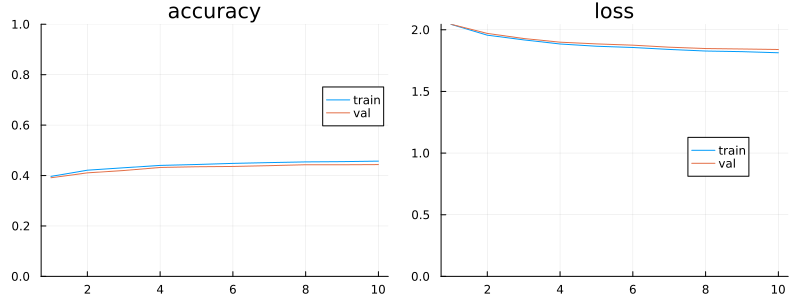

In [11]:
epochs = 1:length(history["train_full_loss"])
p1 = plot(epochs, history["train_full_accuracy"], label="train")
plot!(p1, epochs, history["val_full_accuracy"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_full_loss"], label="train")
plot!(p2, epochs, history["val_full_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(model_dir, "history.png"))
p

## Tokens

In [12]:
tokens = indexer(collect(text))
n_val = floor(Int, (1 - 0.05) * length(tokens))
train_data = tokens[1:n_val]
val_data = tokens[(n_val + 1):end];

println("train tokens:      ", length(train_data))
println("validation tokens: ", length(val_data))

train tokens:      4715037
validation tokens: 248160


In [13]:
val_generator = BatchGenerator(
    val_data;
    context_size=context_size,
    batch_size=32
)

BatchGenerator{Vector{Int64}, TaskLocalRNG}([60, 48, 45, 65, 2, 43, 55, 61, 52, 44  …  16, 64, 45, 61, 54, 60, 8, 40, 39, 1], 32, 32, 7755, TaskLocalRNG())

In [14]:
metrics = batched_metrics(model, val_generator, full_loss, full_accuracy)
@printf "val_acc=%.4f%% ; " metrics.full_accuracy * 100
@printf "val_loss=%.4f \n" metrics.full_loss

batch metrics... 100%|███████████████████████████████████| Time: 0:00:06


val_acc=44.2896% ; val_loss=1.8420 


In [15]:
perplexity = exp(metrics.full_loss)
perplexity

6.309028f0

## Generation

In [16]:
rng = MersenneTwister(2)
context = reshape([1], 1, 1)
context = generate(rng, model, context; context_size=context_size, max_tokens=500)
decoded_context = decode(indexer, context[:, 1])
println(join(decoded_context))


CLATIO.
No, Goe, him buchieds is, hand I was,
To queer thee that of till moxselat by twish are.

BENET.
Are warrain Astier, the Cowlles,
bourse and nope, Merfore myen our to of them coun-mothared man,
Here is
Mafter my thath and herop, and in in have low’t so, veriege a the can eeset thy
inscestle marriom.

ADY.
Thus him stome
To so an streeward. Here cas, which id renuderser what thou bee of as the hightseleh-to.

CHAESS.
With he mand, th’ fouthos. I purcot Lay,
You.

GATHENT.
Who, to hath fres


## Losses

In [17]:
val_generator = BatchGenerator(
    val_data;
    context_size=context_size,
    batch_size=32
);

In [18]:
function context_loss(Ŷ::AbstractArray{T, 3}, Y::AbstractMatrix{Int}, c::Int) where T
    # calculate the loss for only the generation part (last row)
    vocab_size = size(Ŷ, 1) 
    Ygen = Ŷ[:, c, :] # (vocab_size, B)
    Y = Flux.onehotbatch(Y[c, :], 1:vocab_size) # (vocab_size, B)
    Flux.logitcrossentropy(Ygen, Y) 
end

function context_accuracy(Ŷ::AbstractArray{T, 3}, Y::AbstractMatrix{Int}, c::Int) where T
    # calculate the accuracy for only the generation part (last row)
    ygen = Flux.onecold(Ŷ[:, c, :]) # (1, B)
    y = Y[c, :] # (1, B)  
    mean(ygen .== y) 
end

context_accuracy (generic function with 1 method)

In [19]:
results = zeros(Float32, context_size)
num_observations = 0
@showprogress for (x, y) in val_generator
    y_model = model(x)
    values = map(c->context_loss(y_model, y, c), 1:context_size)
    batch_size = count_observations(x) 
    results .+= values .* batch_size
    num_observations += batch_size
end
results /= num_observations;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:039m


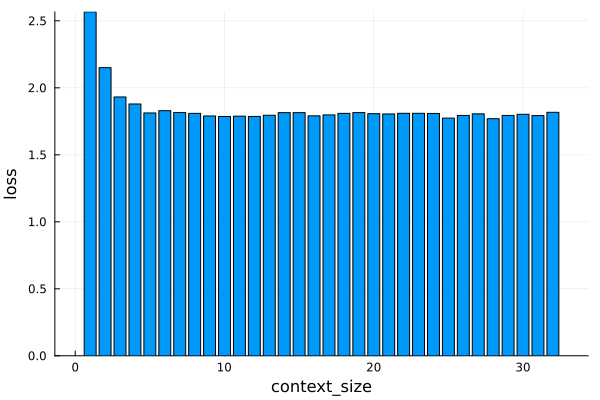

In [20]:
p = bar(results, label="",
    ylabel="loss",
    xlabel="context_size",
)
savefig(p, joinpath(model_dir, "context_loss.png"))
p